In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
    except RuntimeError as e:
        print(e)

from helpers import load_config
from helpers.logging import print_status_bar
from helpers.evaluation import compute_bleu

from sklearn.model_selection import train_test_split
import string
import numpy as np
import io
import os
from time import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/home/esbel/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
config = load_config("config.json")

# Download Dataset

In [3]:
dataset_params = config["dataset"]
path_to_zip = tf.keras.utils.get_file(os.path.join(os.getcwd(), "datasets", "fra-eng.zip"), origin=dataset_params["url"], extract=True)
path_to_file = os.path.join(os.path.dirname(path_to_zip), "fra.txt")

# Preprocessing

In [4]:
def clean_sentence(sentence):
    # make a space between each punctionation
    sentence = sentence.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    
    sentence = sentence.strip()  # remove spaces
    return sentence

def preprocess_a_sentence(sentence):
    # clean it
    sentence = clean_sentence(sentence)
    # add the start and end of sequences
    return '<sos> {} <eos>'.format(sentence)

def load_dataset(path, num_examples=None):
    with open(path, encoding='utf-8') as f:
        lines = f.read().strip().split("\n")
    # list containing a set of (input, output)
    sentence_pairs = [[preprocess_a_sentence(sen) for sen in line.split('\t')]  for line in lines[:num_examples]]
    return zip(*sentence_pairs)

In [5]:
def get_tokenizer(lang, top_k=None):
    
    # we are keeping the punctionation
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, filters='’,?!"#$%&()*+-/:;=.@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(lang)
    
    sequences = tokenizer.texts_to_sequences(lang)
    # pad the tensors
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="post")
    return sequences, tokenizer

def create_dataset(X, y, batch_size=None, buffer=False, prefetch=tf.data.experimental.AUTOTUNE):
    a_set = tf.data.Dataset.from_tensor_slices((X, y))
    if buffer:
        a_set = a_set.shuffle(X.shape[0])
    if batch_size is not None:
        a_set = a_set.batch(batch_size, drop_remainder=True)
    return a_set.prefetch(prefetch)

def dataset(path, batch_size, num_examples=None, prefetch=tf.data.experimental.AUTOTUNE, 
            test_size=0.2, top_k=None):
    target_lang, input_lang = load_dataset(path, num_examples=num_examples)
    
    input_train_seq, input_test_seq, target_train_seq, target_test_seq = train_test_split(input_lang, 
                                                                                          target_lang, 
                                                                                          test_size=test_size)
    
    input_train_seq, input_tokenizer = get_tokenizer(input_train_seq, top_k=top_k)
    target_train_seq, target_tokenizer = get_tokenizer(target_train_seq, top_k=top_k)
    
    input_test_seq = input_tokenizer.texts_to_sequences(input_test_seq)
    input_test_seq = tf.keras.preprocessing.sequence.pad_sequences(input_test_seq, padding="post", 
                                                                   maxlen=input_train_seq.shape[-1])
    
    target_test_seq = target_tokenizer.texts_to_sequences(target_test_seq)
    target_test_seq = tf.keras.preprocessing.sequence.pad_sequences(target_test_seq, padding="post", 
                                                                    maxlen=target_train_seq.shape[-1])
    
    
    train_set = create_dataset(input_train_seq, target_train_seq, 
                               batch_size=batch_size, buffer=True,
                               prefetch=prefetch)
    test_set = create_dataset(input_test_seq, target_test_seq, prefetch=prefetch)
    
    # information about the training set:
    info = dict(
        train_size=input_train_seq.shape[0],
        train_input_max_pad=input_train_seq.shape[1],
        train_target_max_pad=target_train_seq.shape[1]
    )
    return train_set, test_set, info, input_tokenizer, target_tokenizer

In [6]:
batch_size = dataset_params["batch_size"]
num_examples = dataset_params["num_examples"]
top_k = dataset_params['top_common_words']
train_set, test_set, info, input_tokenizer, target_tokenizer = dataset(path_to_file, batch_size, 
                                                                             num_examples=num_examples,
                                                                             top_k=top_k)

In [7]:
for x, y, in train_set.take(1):
    i = 10
    print(input_tokenizer.sequences_to_texts([x[i].numpy()]))
    print(target_tokenizer.sequences_to_texts([y[i].numpy()]))

['<sos> il y avait une ressemblance frappante entre elles <eos>']
['<sos> there was a striking resemblance between them <eos>']


# Model

## Setting Hyperparameters

In [8]:
model_config = config['model']
N = model_config['N']
model_depth = model_config['model_depth']
num_heads = model_config['num_heads']
dff = model_config['dff']
dropout_rate = model_config['dropout_rate']
epochs = model_config['epochs']


steps_per_epoch = info['train_size'] // batch_size
max_input_vocab = len(input_tokenizer.index_word) + 1
max_target_vocab = len(target_tokenizer.index_word) + 1
input_max_positional_encoding = max_input_vocab
target_max_positional_encoding = max_target_vocab

## Build

In [9]:
from model import Transformer, CustomSchedule
transformer = Transformer(N, model_depth, num_heads, dff, 
                          max_input_vocab, max_target_vocab, 
                          input_max_positional_encoding, target_max_positional_encoding, 
                          rate=dropout_rate)

## Compile

Where are going to use adam optimizer with a custom LR:

$$l_{\text{rate}} = d_{\text{model}}^{-0.5} * \text{min}(\text{step_num}^{-0.5}, \text{step_num} * \text{warmup_steps}^{-1.5})$$

In [10]:
learning_rate = CustomSchedule(model_depth)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Training

Training steps are as following:

- Prepare the target language input and output:
    - The output target should be shifted 1 step.
- Use teacher forcing for predicting until <end> token or max size.

In [12]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer((inp, tar_inp), training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [13]:
for epoch in range(epochs):
    start = time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (step, (inp, tar)) in enumerate(train_set):
        train_step(inp, tar)

        print_status_bar(step * batch_size, info['train_size'], train_loss, None)
    
    print_status_bar(info['train_size'], info['train_size'], train_loss, None)
    print ('Time taken for epoch {}: {} secs\n'.format(epoch, time() - start))

133704/133704 [==============================] - train_loss: 1.0605
Time taken for epoch 0: 681.9172124862671 secs

133704/133704 [==============================] - train_loss: 0.4252
Time taken for epoch 1: 655.2499189376831 secs

133704/133704 [==============================] - train_loss: 0.3851
Time taken for epoch 2: 653.0635752677917 secs

133704/133704 [==============================] - train_loss: 0.3518
Time taken for epoch 3: 655.8869280815125 secs

133704/133704 [==============================] - train_loss: 0.3333
Time taken for epoch 4: 656.945113658905 secs

133704/133704 [==============================] - train_loss: 0.3164
Time taken for epoch 5: 655.4573316574097 secs

133704/133704 [==============================] - train_loss: 0.3030
Time taken for epoch 6: 655.4511797428131 secs

133704/133704 [==============================] - train_loss: 0.2942
Time taken for epoch 7: 651.7164719104767 secs

133704/133704 [==============================] - train_loss: 0.2853
Time 

# Evaluation

The following steps are used for evaluation:

- Encode the input sentence using the input tokenizer and add the necessary starting and ending tokens
- Create a decoder input and set the first value to start token
- Calculate the padding masks and the look ahead masks.
- The decoder outputs the predictions by looking at the encoder's output and its own output.
- Select the last work and calculate the argmax of that.
- Concatentane the predicted word of input and refeed the decoder until the end token is predicted.

In [31]:
def plot_attention_weights(attention, sentence, result, layer, savefig=False):
    fig = plt.figure(figsize=(16, 8))

    sentence = sentence.split(" ")

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-0.5, -0.5)

        ax.set_xticklabels(sentence, 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels(result, 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    if savefig:
        plt.savefig("results/{}.png".format(time()), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


def evaluate(X, target_max_length):
    
    enc_input = tf.expand_dims(X, axis=0)
    dec_input = tf.expand_dims([target_tokenizer.word_index['<sos>']], axis=0)
    
    result = []
    for i in range(target_max_length):
    
        predictions, atten_dict = transformer((enc_input, dec_input), training=False)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        last_prediction_id = predicted_id.numpy()[0][0]
        
        if last_prediction_id == 0:
            predicted_word = "<pad>"
        else:
            predicted_word = target_tokenizer.index_word[last_prediction_id]
        
        if predicted_word  == '<eos>':
            return result, atten_dict
        
        result.append(predicted_word)
        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        dec_input = tf.concat([dec_input, predicted_id], axis=-1)
    
    return result, atten_dict

In [33]:
def translate(X, y, plot='', savefig=False):
    sentence = input_tokenizer.sequences_to_texts([X.numpy()])[0]
    translation = target_tokenizer.sequences_to_texts([y.numpy()])[0]
    predicted_arr, attention_weights = evaluate(X, y.shape[0])
    predicted_sentence = ' '.join(word for word in predicted_arr)
    
    print('Input: {}'.format(sentence))
    print('Actual translation: %s' % (translation))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, predicted_arr, plot, savefig=savefig)

Input: <sos> dieu créa le monde <eos>
Actual translation: <sos> god created the world <eos>
Predicted translation: god does the world


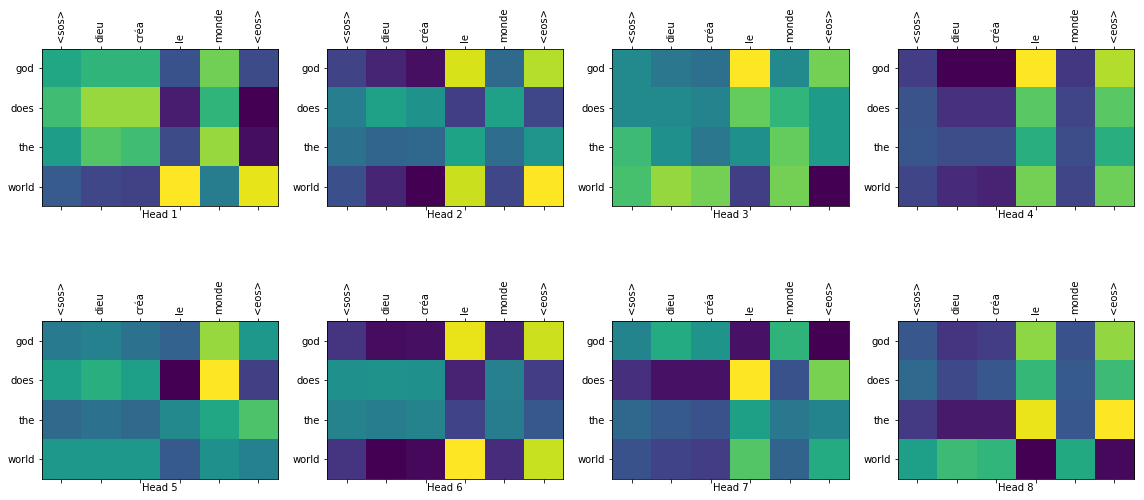

Input: <sos> pourriez vous être silencieux <eos>
Actual translation: <sos> could you please be quiet <eos>
Predicted translation: you may be quiet


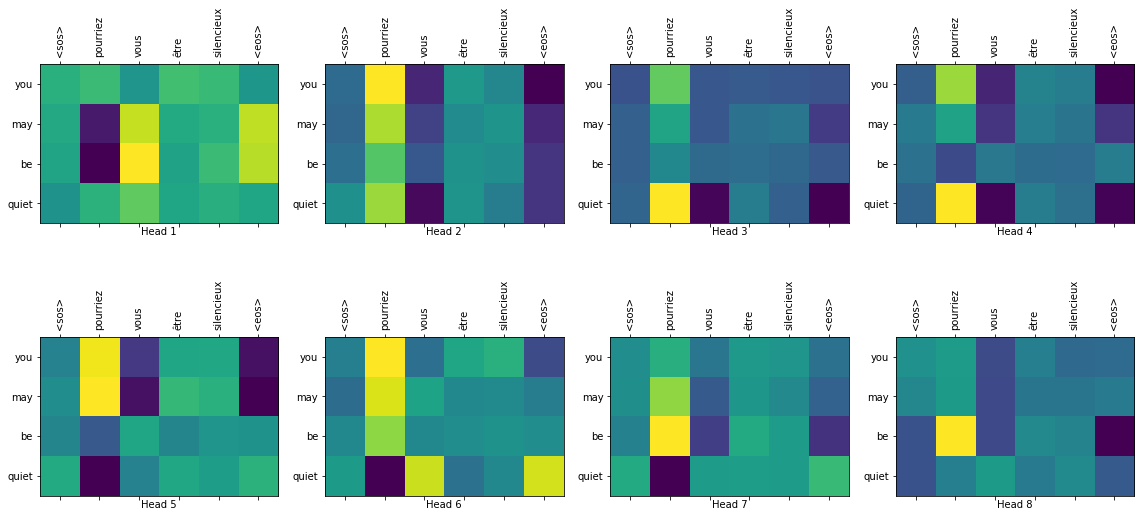

Input: <sos> je sais que je ne veux pas être marié avec toi <eos>
Actual translation: <sos> i know that i don ' t want to be married to you <eos>
Predicted translation: i know you ' re really want to be married


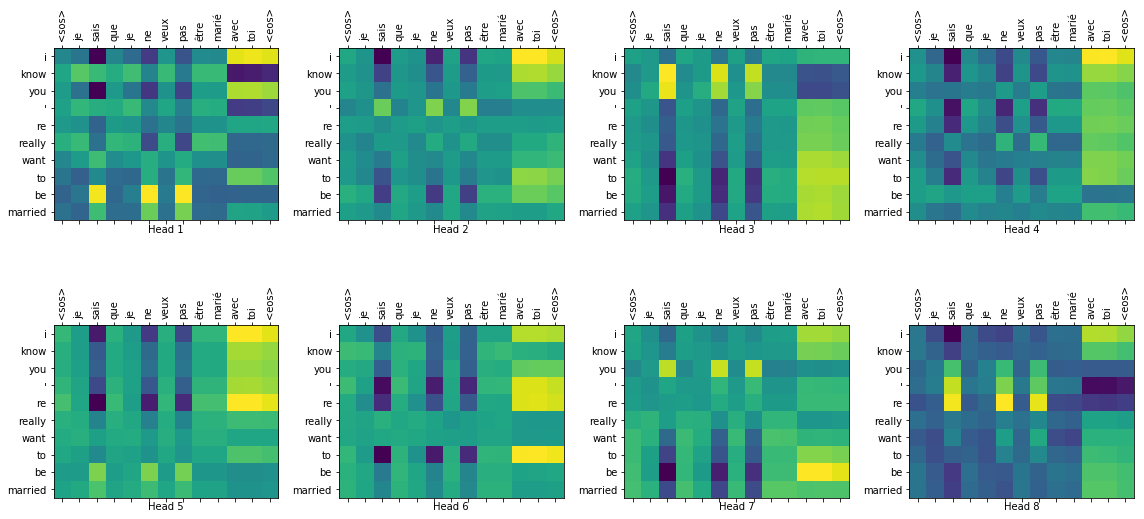

Input: <sos> tom n ' enleva pas son chapeau <eos>
Actual translation: <sos> tom didn ' t take off his hat <eos>
Predicted translation: tom didn ' t take his hat off


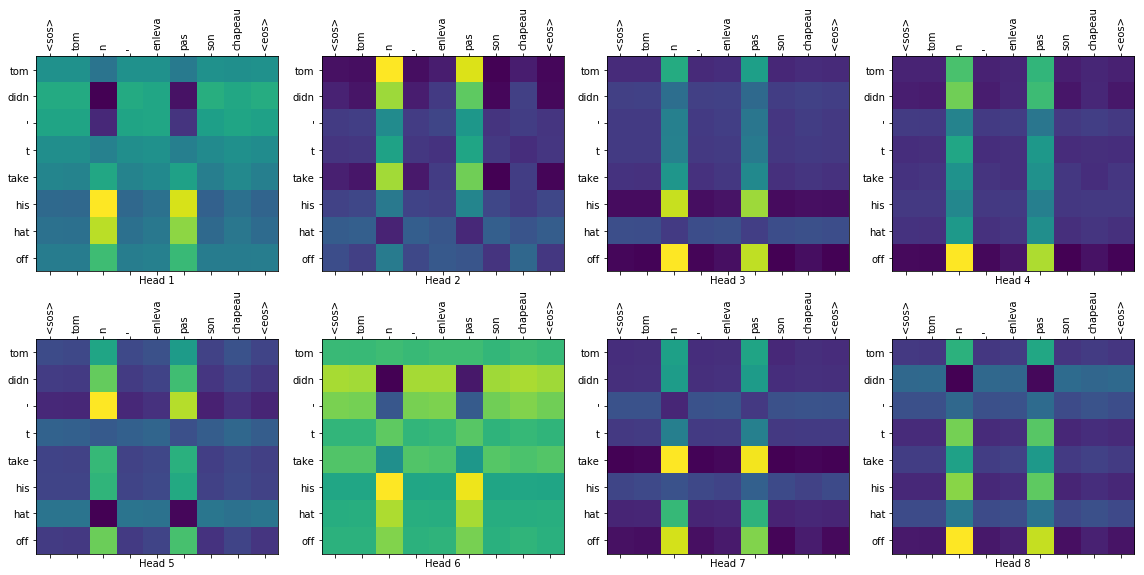

Input: <sos> où étais tu toute l ' après midi  <eos>
Actual translation: <sos> where were you for the whole afternoon <eos>
Predicted translation: where were you all afternoon


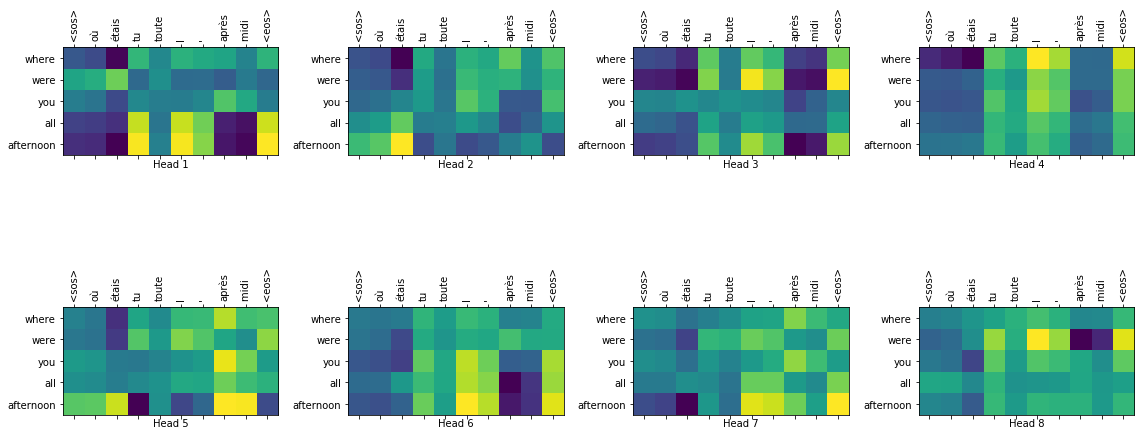

In [35]:
for X, y in test_set.shuffle(1000).take(5):
    boolean_mask = tf.cast(X, dtype=tf.bool)              
    X = tf.boolean_mask(X, boolean_mask, axis=0)
    translate(X, y, plot='decoder_layer6_block2', savefig=True)

# References and Further readings.

- [Attention is all you need](https://arxiv.org/abs/1706.03762)
- [Tensorflow Transformer tutorial](https://www.tensorflow.org/tutorials/text/transformer)
- [The illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [Hands-on ML with Scikit-learn, keras and Tensorflow](https://github.com/ageron/handson-ml2)
- [Python BLEU Score implementation](https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py)